# Playing with exchange-rates

## Exploring foreign exchange rates (per USD) for 22 countries, data from years 2000-19 

##### Dataset can be obtained from https://www.kaggle.com/brunotly/foreign-exchange-rates-per-dollar-20002019

Exchange rates, despite being mere floating point numbers, actually tell you a lot about the economy of a country. It can also give you insights into where the entire world economy is headed. Moreover, important political events create unique features in the plots of exchange rates over time. For instance, Luiz "Lula" da Silva's election as President for the first time in 2002 might be correlated with the bump in the Brazilian Real exchange rate. 

In [2]:
#dataset in file Foreign_Exchange_Rates.csv
#import libraries 
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv('Foreign_Exchange_Rates.csv')
df.head(5)

,Unnamed: 0,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,...,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,...,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,...,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,...,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,...,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3


### Data cleaning/preprocessing
Here we perform the following transformations:
1. Renaming columns to shorter, more accessible names: for example, 'Euro Area - Euro/US\\$' gets shortened to 'Euro_Area'.

2. Exchange rates are converted to numeric values, so that we can perform arithmetic manipulations with them.
3. Dates are converted into Pandas standard Date Time format
4. Certain rows of exchange rate values in the dataset are labelled as "ND". Given that we have enough valid numerical data already, our conclusions won't change significantly if we drop rows containing such non-numerical values.

In [156]:
#rename 'Time Serie' to 'Date', 'Unnamed: 0' to 'Index', other columns, for readability purposes
renamed_columns = {x:x.split(' -')[0].title().replace(' ','_') for x in df.columns}
renamed_columns['Time Serie'] = 'Date'
renamed_columns['Unnamed: 0'] = 'num_entry'
df = df.rename(columns = renamed_columns)

#convert exchange rates to floats
rate_cols = list(df.columns.difference(['Date','num_entry']))
df[rate_cols] = df[rate_cols].apply(pd.to_numeric, errors='coerce') 

#convert date into pandas DateTime format
df['Date'] = df['Date'].apply(pd.to_datetime, format="%Y-%m-%d")

#drop unsuccessful conversions
df = df.dropna(axis=0)

#first few rows of the dataset
df[['Date']+rate_cols].head()

,Date,Australia,Brazil,Canada,China,Denmark,Euro_Area,Hong_Kong,India,Japan,...,New_Zealand,Norway,Singapore,South_Africa,Sri_Lanka,Sweden,Switzerland,Taiwan,Thailand,United_Kingdom
0,2000-01-03,1.5172,1.8050,1.4465,8.2798,7.3290,0.9847,7.7765,43.55,101.70,...,1.9033,7.964,1.6563,6.126,72.30,8.4430,1.5808,31.38,36.97,0.6146
1,2000-01-04,1.5239,1.8405,1.4518,8.2799,7.2180,0.9700,7.7775,43.55,103.09,...,1.9238,7.934,1.6535,6.085,72.65,8.3600,1.5565,30.60,37.13,0.6109
2,2000-01-05,1.5267,1.8560,1.4518,8.2798,7.2080,0.9676,7.7780,43.55,103.77,...,1.9339,7.935,1.6560,6.070,72.95,8.3530,1.5526,30.80,37.10,0.6092
3,2000-01-06,1.5291,1.8400,1.4571,8.2797,7.2125,0.9686,7.7785,43.55,105.19,...,1.9436,7.940,1.6655,6.080,72.95,8.3675,1.5540,31.75,37.62,0.6070
4,2000-01-07,1.5272,1.8310,1.4505,8.2794,7.2285,0.9714,7.7783,43.55,105.17,...,1.9380,7.966,1.6625,6.057,73.15,8.4150,1.5623,30.85,37.30,0.6104


### I. Plotting all exchange rates, after grouping into continents
Here we plot the exchange rates for all the 22 countries by grouping them into continents. However, as different currencies have different evaluations with respect to the US Dollar, we divide each exchange rate by its value on the first date in the series, namely January 3, 2000. 

In [157]:
#group into countries
African_countries = ['South_Africa']
American_countries = ['Brazil', 'Canada', 'Mexico']
Asian_countries = ['China', 'Hong_Kong', 'India', 'Japan', 'Korea', 'Malaysia', 'Singapore', 'Sri_Lanka', 'Taiwan', 'Thailand']
Australian_countries = ['Australia', 'New_Zealand']
European_countries = ['Denmark', 'Euro_Area', 'Norway', 'Sweden', 'United_Kingdom']

In [158]:
#create df_normalized by dividing each exchange rate by the rate on January 3, 2000
#df_normalized is used when plotting all the exchange rates within the same plot
df_normalized = df.copy()
for col in rate_cols:
    x = df.loc[0,col]
    df_normalized[col]/=x

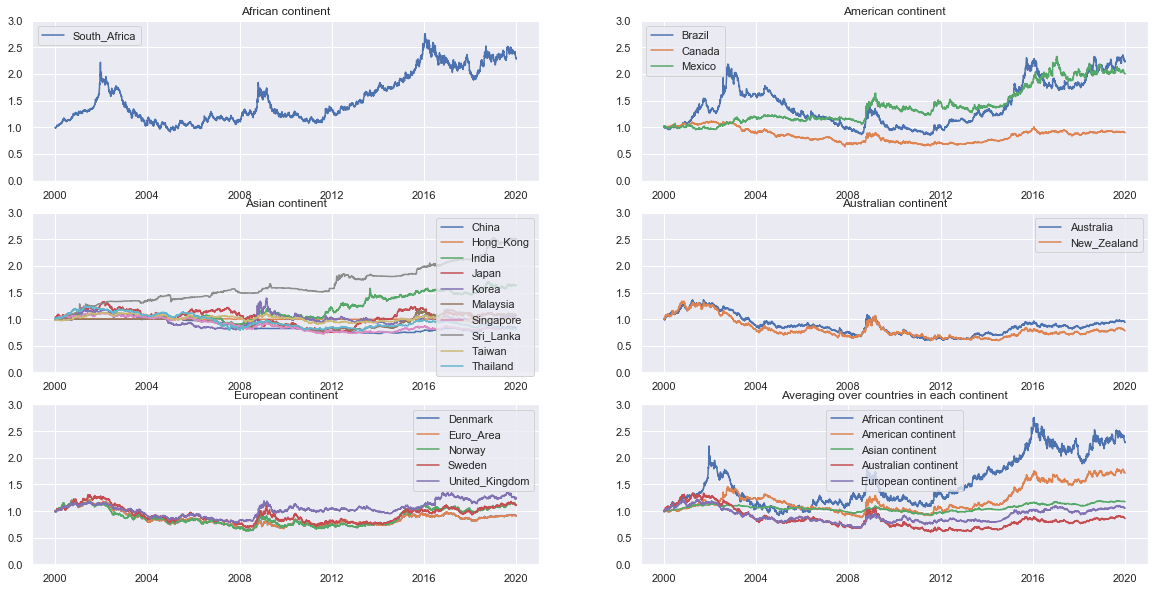

In [159]:
#plot all the exchange rates (df_normalized)
fig,plots =  plt.subplots(3,2,figsize=(20,10))

#Plot 1: Africa
current_subplot = plots[0][0]
current_subplot.plot(df['Date'],df_normalized[African_countries])
current_subplot.legend(African_countries)
current_subplot.set_ylim([0,3])
current_subplot.set_title('African continent')

#Plot 2: North and South America
current_subplot = plots[0][1]
current_subplot.plot(df['Date'],df_normalized[American_countries])
current_subplot.legend(American_countries)
current_subplot.set_ylim([0,3])
current_subplot.set_title('American continent')

#Plot 3: Asia
current_subplot = plots[1][0]
current_subplot.plot(df['Date'],df_normalized[Asian_countries])
current_subplot.legend(Asian_countries)
current_subplot.set_ylim([0,3])
current_subplot.set_title('Asian continent')

#Plot 4: Australia
current_subplot = plots[1][1]
current_subplot.plot(df['Date'],df_normalized[Australian_countries])
current_subplot.legend(Australian_countries)
current_subplot.set_ylim([0,3])
current_subplot.set_title('Australian continent')

#Plot 5: Europe
current_subplot = plots[2][0]
current_subplot.plot(df['Date'],df_normalized[European_countries])
current_subplot.legend(European_countries)
current_subplot.set_ylim([0,3])
current_subplot.set_title('European continent')

#Plot 6: average over countries within each group
af_mean = df_normalized[African_countries].mean(axis=1)
am_mean = df_normalized[American_countries].mean(axis=1)
as_mean = df_normalized[Asian_countries].mean(axis=1)
au_mean = df_normalized[Australian_countries].mean(axis=1)
eu_mean = df_normalized[European_countries].mean(axis=1)
current_subplot = plots[2][1]
current_subplot.plot(df['Date'],pd.concat([af_mean, am_mean, as_mean, au_mean, eu_mean], axis=1))
current_subplot.legend(['African continent','American continent','Asian continent','Australian continent','European continent'])
current_subplot.set_ylim([0,3])
current_subplot.set_title('Averaging over countries in each continent')

#show plot
plt.show()

#### Conclusions from the plots above:
1. We can see that all non-Asian economies have a noticeable hump feature in the exchange rate around 2009. Obviously, this is due to the 2008 recession. 
2. Of the 22 economies, South Africa seems to have the widest range in its exchange rate per US dollar. This is an interesting feature. Moreover, there are spikes in 2002, 2009 and 2016. The 2009 spike must be due to recession just like all other economies, whereas the 2016 spike could be due to the ouster of Jacob Zuma from presidency.
3. On a related note, we see Brazil's exchange rate spiking around 2003. 


### II. Looking at correlations
It is interesting to explore correlations in this dataset between various Forex rates. We use Pearson's coefficient to do so. Seaborn has been used for plotting purposes. We plot correlations among Asian Forex rates. Feel free to modify df[Asian_countries] to df[rate_cols] to extend the correlation matrix to all countries in this dataset.

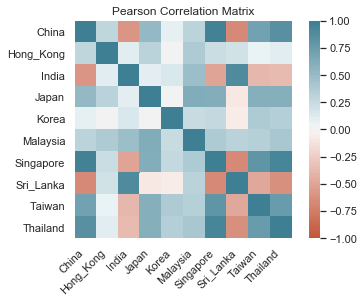

In [160]:
corr = df[Asian_countries].corr()
#corr = df[rate_cols].corr() #activate this line to look at correlations among all 22 Forex rates

#Seaborn correlation matrix plot
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.set_title('Pearson Correlation Matrix');

### III. Some fun with this data, looking at lower dimensional projections
At any point of time, each of these 22 economies have some exchange rate. So essentially we have a 22 dimensional vector that crudely indicates the state of the world economy. So I thought: well, why not try to find a low-dimensional approximation by running a PCA! After all, from the plots for the Australian continent, it is clear that Australia and New Zealand move in tandem. There might be more hidden interdependencies. After all, it's a small world, eh?

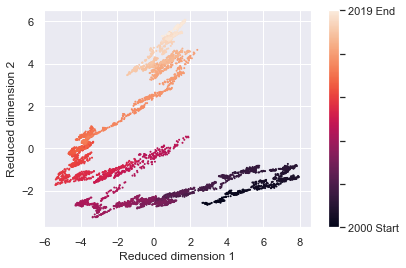

In [161]:
#trying PCA with the dataset
df[rate_cols] = StandardScaler().fit_transform(df[rate_cols])

N_pca = 2
pca = PCA(n_components=N_pca)
principalComponents = pca.fit_transform(df[rate_cols])
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component {}'.format(i) for i in range(1,N_pca+1)]
                          )
plt.scatter(principalComponents[:,0],principalComponents[:,1],s=1,c=range(principalComponents.shape[0]))
plt.xlabel('Reduced dimension 1')
plt.ylabel('Reduced dimension 2')
cb = plt.colorbar()
cb.ax.set_yticklabels(['2000 Start','','','','','2019 End'])
plt.show()

### IV. Inherent assumptions and limitations
1. Everything is normalized with respect to US Dollars
2. Some continents have very few countries. For instance, merely having South Africa in my list doesn't mean that the South African currency exchange rates give me a holistic view of the entire African continent.
3. In the plots for each continent, we are averaging currencies by assigning uniform weights to each of them. For instance, the Chinese and Malaysian GDP are vastly different, still they have an equal say when we take a straightforward average over them to know the state of the Asian economy.
